In [1]:
import numpy as np
import pandas as pd
import time
test  = pd.read_csv("https://s3.amazonaws.com/hackerday.datascience/112/test.csv")  
train = pd.read_csv("https://s3.amazonaws.com/hackerday.datascience/112/train.csv") 

print("Number of features in Train : ", train.shape[1])
print("Number of records  in Train : ",train.shape[0])
print("Number of features in Test  : ",test.shape[1])
print("Number of records  in Test  : ",test.shape[0])

trainData  = train.drop(['subject','Activity'] , axis=1).values
trainLabel = train.Activity.values

testData  = test.drop(['subject','Activity'] , axis=1).values
testLabel = test.Activity.values


print("Train Data shape  : ",trainData.shape)
print("Train Label shape : ",trainLabel.shape)
print("Test Data  shape  : ",testData.shape)
print("Test Label shape  : ",testLabel.shape)

print("Label examples: ")
print(np.unique(trainLabel))

Number of features in Train :  563
Number of records  in Train :  999
Number of features in Test  :  563
Number of records  in Test  :  999
Train Data shape  :  (999, 561)
Train Label shape :  (999,)
Test Data  shape  :  (999, 561)
Test Label shape  :  (999,)
Label examples: 
['LAYING' 'SITTING' 'STANDING' 'WALKING' 'WALKING_DOWNSTAIRS'
 'WALKING_UPSTAIRS']


In [2]:
from sklearn import preprocessing
from sklearn import utils

ltrain = preprocessing.LabelEncoder()
ltest = preprocessing.LabelEncoder()

trainLabel = ltrain.fit_transform(trainLabel)
testLabel  = ltest.fit_transform(testLabel)

print(np.unique(trainLabel))
print(np.unique(testLabel))
print("Train Label shape : ",trainLabel.shape)
print("Test Label shape  : ",testLabel.shape)
print(utils.multiclass.type_of_target(testLabel))

[0 1 2 3 4 5]
[0 1 2 3 4 5]
Train Label shape :  (999,)
Test Label shape  :  (999,)
multiclass


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.utils import shuffle

t0 = time.clock()
# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(6),
              scoring='accuracy')
# Before training the data it is convenient to shuffle the data in training
np.random.seed(1)
print("Labels before Shuffle",testLabel[0:5])
testData,testLabel = shuffle(testData,testLabel)
trainData,trainLabel = shuffle(trainData,trainLabel)
print("Labels after Shuffle",testLabel[0:5])

Labels before Shuffle [2 2 2 2 2]
Labels after Shuffle [1 5 5 0 3]


C:\Users\danie\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  


In [4]:
# train and fit data in the model
rfecv.fit(trainData, trainLabel)

print("Optimal number of features : %d" % rfecv.n_features_)
print("Processing time sec ",time.clock() - t0)

Optimal number of features : 159
Processing time sec  260.776807759


C:\Users\danie\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """


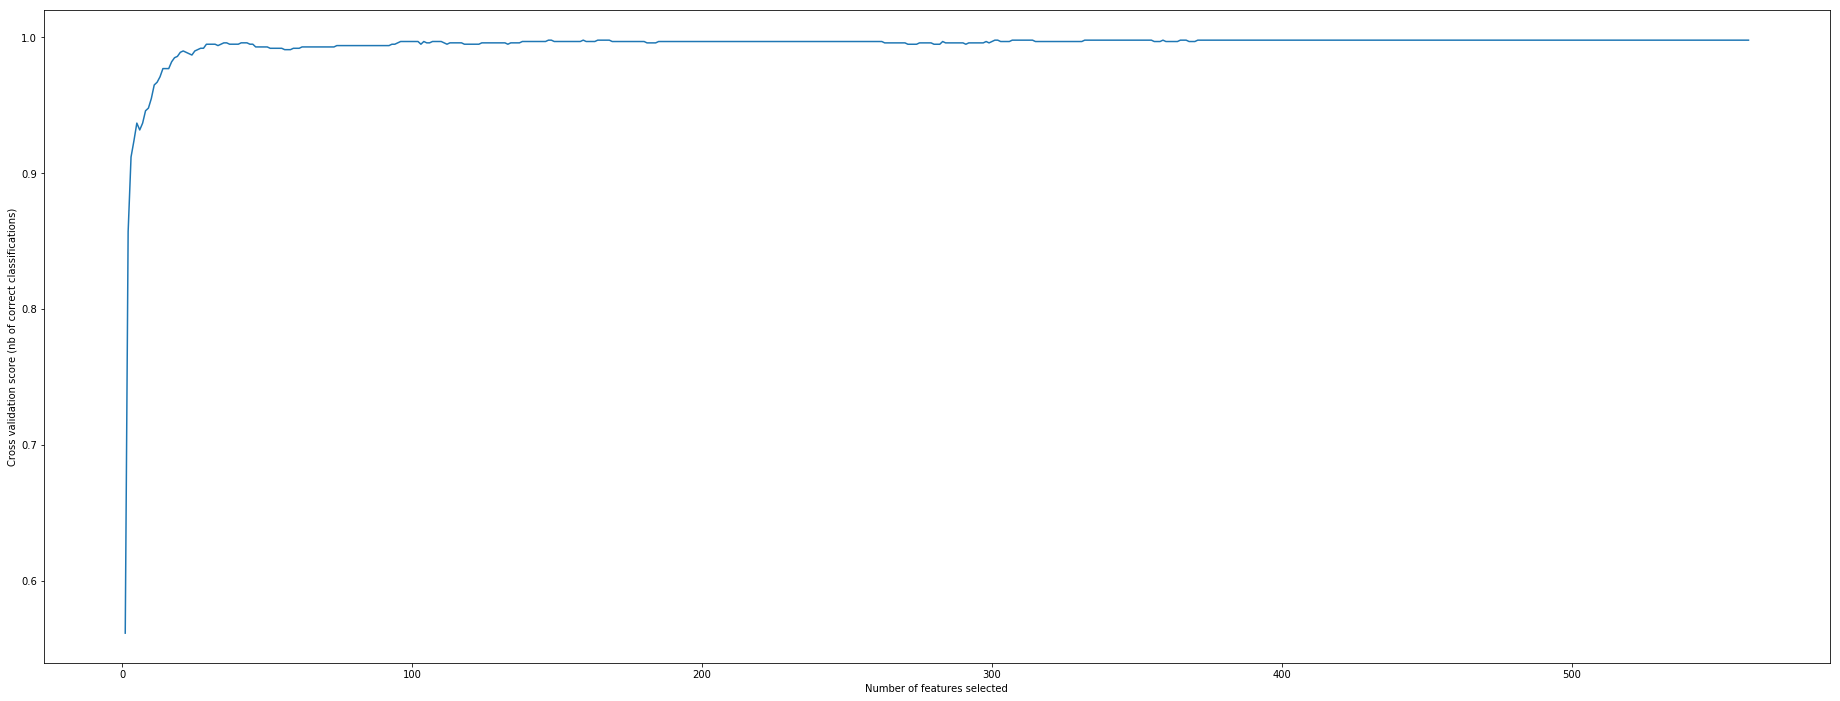

In [5]:
# Plot number of features VS. cross-validation scores
plt.figure(figsize=(32,12))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [6]:
print('Accuracy of the SVM model on test data is ', rfecv.score(testData,testLabel) )
print('Ranking of features starting from the best estimated \n',rfecv.ranking_)
# if we mask the features to get only the best we get this
best_features = []
for ix,val in enumerate(rfecv.support_):
    if val==True:
        best_features.append(testData[:,ix])

Accuracy of the SVM model on test data is  0.8748748748748749
Ranking of features starting from the best estimated 
 [297 354 309   1   1 219   1   1 200   1 240 263 144 151 312 147  83 230
 252 116   1 185   1   1 154 158  92 268   1  46   1   4   1   1 216  35
   1   1   1   1   1   1  95 316 285 165 325 294 146   1   1  68   1   1
 142   1   1   1  25 348 262 107   1   1   1   1   1   1   1   1   1  20
  45   1   1  77  97   1  18  89 273  76   3  70  48 281 112  39 223   1
  30 115  43   1 121 203 247 239 381 166   1 127   1   5   1  82   1   1
   1  99  52  21   1 140  36 220   1   1   1   1 244 119 123 170 210 272
 250 145 179   1 245 214 217 300 153 255 258 321 310 164  50 139   1   1
   1   1  60   1  13  29  88 160   1  31 100 168   1   1   1   1 290 352
  75 150 211 246 172 163 260  98 177   1 180 306 292 271 345 368 379  84
  38 233   1   1   1   1   1  12   1   1 148   1   1   6  69 109   1   1
   1   1 138   1  59   1 178 122 194 238  65   1   1 102  57 130   1  49
   1 15

(999, 159)


C:\Users\danie\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  after removing the cwd from sys.path.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E109EE4BA8>,
      dtype=object)

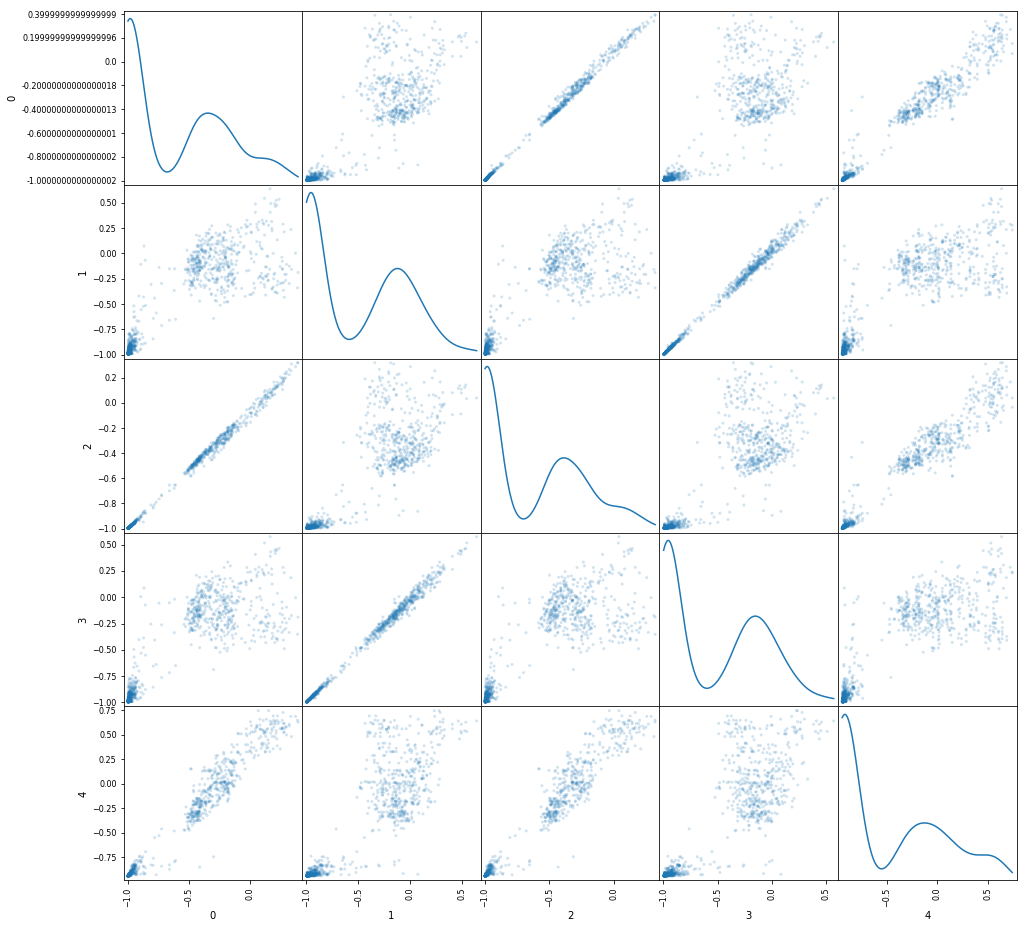

In [7]:
from pandas.tools.plotting import scatter_matrix
visualize = pd.DataFrame(np.asarray(best_features).T)
print(visualize.shape)
scatter_matrix(visualize.iloc[:,0:5], alpha=0.2, figsize=(16, 16), diagonal='kde')

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

X, y = train.iloc[:, 0:len(train.columns) - 1], train.iloc[:, -1]
X_test, y_test = test.iloc[:, 0:len(test.columns) -1], test.iloc[:, -1]

parameters = {
    'kernel': ['linear', 'rbf', 'poly','sigmoid'],
    'C': [100, 50, 20, 1, 0.1]
}

selector = GridSearchCV(SVC(), parameters, scoring='accuracy') # we only care about accuracy here
selector.fit(X, y)

print('Best parameter set found:')
print(selector.best_params_)
print('Detailed grid scores:')
means = selector.cv_results_['mean_test_score']
stds = selector.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, selector.cv_results_['params']):
    print('%0.3f (+/-%0.03f) for %r' % (mean, std * 2, params))
    print()
clf = SVC(kernel='linear', C=100).fit(X, y)
y_pred = clf.predict(X_test)
print('Accuracy score:', accuracy_score(y_test, y_pred))

Best parameter set found:
{'C': 100, 'kernel': 'linear'}
Detailed grid scores:
0.913 (+/-0.095) for {'C': 100, 'kernel': 'linear'}

0.908 (+/-0.105) for {'C': 100, 'kernel': 'rbf'}

0.901 (+/-0.104) for {'C': 100, 'kernel': 'poly'}

0.907 (+/-0.112) for {'C': 100, 'kernel': 'sigmoid'}

0.913 (+/-0.095) for {'C': 50, 'kernel': 'linear'}

0.906 (+/-0.098) for {'C': 50, 'kernel': 'rbf'}

0.894 (+/-0.085) for {'C': 50, 'kernel': 'poly'}

0.894 (+/-0.132) for {'C': 50, 'kernel': 'sigmoid'}

0.913 (+/-0.095) for {'C': 20, 'kernel': 'linear'}

0.903 (+/-0.102) for {'C': 20, 'kernel': 'rbf'}

0.874 (+/-0.100) for {'C': 20, 'kernel': 'poly'}

0.887 (+/-0.112) for {'C': 20, 'kernel': 'sigmoid'}

0.913 (+/-0.095) for {'C': 1, 'kernel': 'linear'}

0.849 (+/-0.085) for {'C': 1, 'kernel': 'rbf'}

0.636 (+/-0.048) for {'C': 1, 'kernel': 'poly'}

0.759 (+/-0.058) for {'C': 1, 'kernel': 'sigmoid'}

0.899 (+/-0.118) for {'C': 0.1, 'kernel': 'linear'}

0.401 (+/-0.036) for {'C': 0.1, 'kernel': 'rbf'}

0.